In [1]:
import torch
from torch import nn
import random
from PIL import Image
from pathlib import Path
import os


# Check our GPU/CPU environment

In [2]:
!nvidia-smi

Thu Jul 25 15:31:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 551.76       CUDA Version: 12.4     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     On  | 00000000:09:00.0  On |                  Off |
| 45%   38C    P8              26W / 450W |  23967MiB / 24564MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Setup data paths

In [4]:
data_path = Path("../data/smalldataset")

# Setup train and testing paths
train_dir = data_path / "train"
test_dir = data_path / "test"
val_dir = data_path / "val"

train_dir, test_dir, val_dir

(PosixPath('../data/smalldataset/train'),
 PosixPath('../data/smalldataset/test'),
 PosixPath('../data/smalldataset/val'))

In [5]:
data_path

PosixPath('../data/smalldataset')

In [6]:
data_path_files = os.listdir(data_path)
len(data_path_files)

3

In [7]:
# image_path_list = list(data_path.glob("*/*/*.jpg"))
#image_path_list = list(data_path.glob("*/*/*.jpeg")) # for use with Dad's data
image_path_list = list(data_path.glob("*/*/*.jpg")) # for use with Kaggle
len(image_path_list)

0

In [8]:
!pwd

/home/candrews/Projects/MyProjects/GrandMesaWildflowers/notebooks


Image path: ../data/smalldataset/train/Androsace_septentrionalis/Androsace_septentrionalis-Fairy Candelabra-6-23-2016a.jpeg
Image class: Androsace_septentrionalis
Image height: 300
Image width: 300


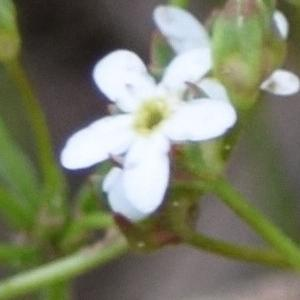

In [9]:

# Set seed
#random.seed(42)

# 1. Get all image paths 
image_path_list = list(data_path.glob("*/*/*.jpeg")) # Dads
#image_path_list = list(data_path.glob("*/*/*.jpg")) # kaggle

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
image = Image.open(random_image_path)

# 5. Print metadata 
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
image

(-0.5, 299.5, 299.5, -0.5)

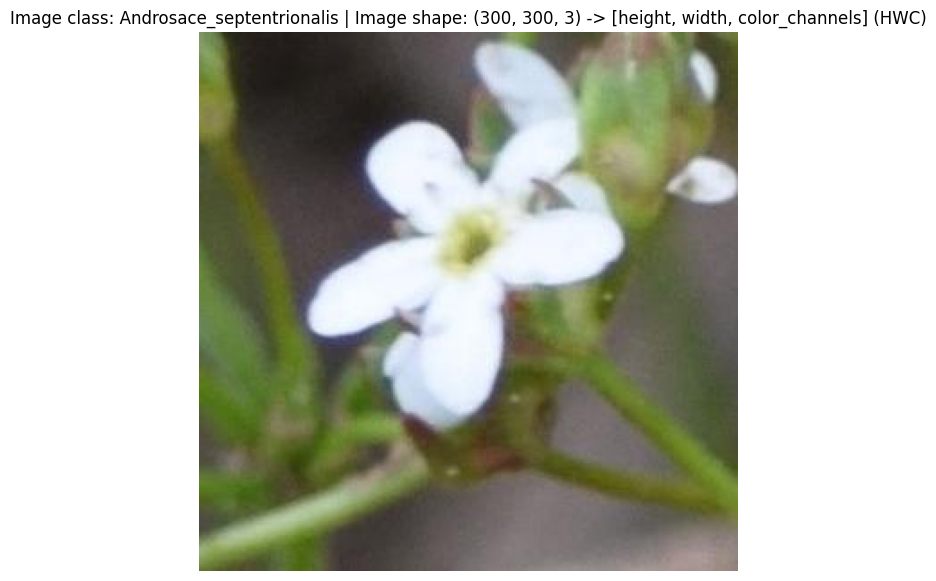

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#check out the array sizes
image_array = np.asarray(image)

plt.figure(figsize=(7,7))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)


# Prepare images for Pytorch
- We need to convert to tensors
-  Make the dataset an actual torch.utils.data.Dataset
-  Create a torch.utils.data.DataLoader

## Convert to Tensors with transforms

In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

my_transformer_0 = transforms.Compose([
    #Resize, as our model (TinyVGG) is going to take 64x64 images
    transforms.Resize(size=(64,64)),
    # can do other cool things  like flips, etc, but will wait
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5), 
    transforms.RandomRotation(degrees=(-180,180)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    # finally, we can use this setup to transform the images into tensors
    transforms.ToTensor()
])


In [12]:
#from aiml_utils.pytorch.utils import plot_transformed_images

# borrowed from Daniel Bourke Pytorch class
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


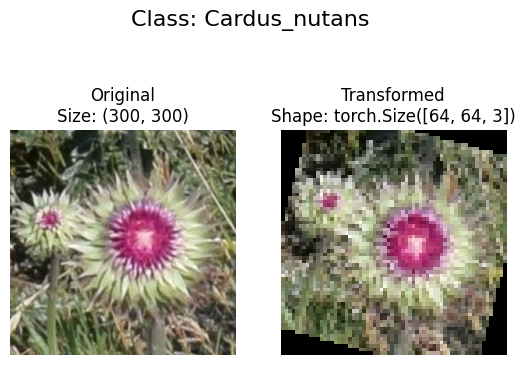

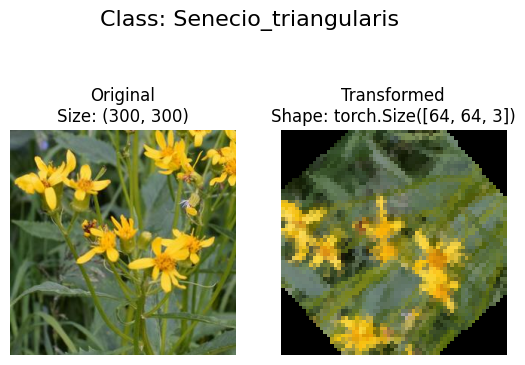

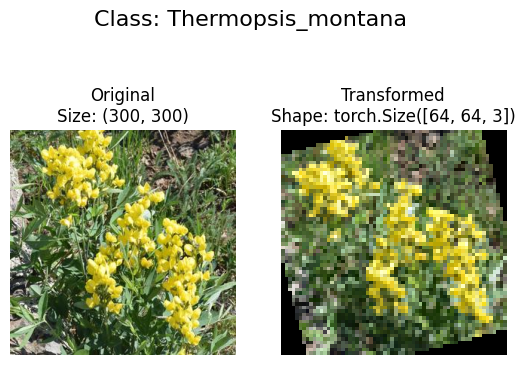

In [13]:
plot_transformed_images(image_paths=image_path_list,
                        transform=my_transformer_0,
                        n=3,
                        seed=None)

# Data Loaders

There are a couple options to use here.  The data was already set up into a structure that ImageFolder can use, so we will start with using that

In [14]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=my_transformer_0,
                                  target_transform=None) # this is a transform for the labels - no need for it here... It is optional

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=my_transformer_0)

val_data = datasets.ImageFolder(root=val_dir,
                                 transform=my_transformer_0)

In [15]:
# Lets look at the classes, to make sure they are as expected
class_names = train_data.classes

In [16]:
train_data.class_to_idx

{'Achillea_millefolium': 0,
 'Aconitum_columbianum': 1,
 'Allium_acuminatum': 2,
 'Allium_cernuum': 3,
 'Amelanchier_alnifolia': 4,
 'Androsace_septentrionalis': 5,
 'Antennaria_rosea': 6,
 'Anticlea_elegans': 7,
 'Aquilegia_coerulea': 8,
 'Caltha_leptosepala': 9,
 'Campanula_rotundifolia': 10,
 'Cardus_nutans': 11,
 'Castilleja_linariifolia': 12,
 'Castilleja_rhexifolia': 13,
 'Castilleja_septentrionalis': 14,
 'Chamaenerion_angustifolium': 15,
 'Clematis_hirsutissima': 16,
 'Corydalis_caseana': 17,
 'Dasiphora_fruticosa': 18,
 'Delphinium_barbeyi': 19,
 'Eremogone_fendleri': 20,
 'Erigeron_coulteri': 21,
 'Erigeron_divergens': 22,
 'Erigeron_flagellaris': 23,
 'Erigeron_speciosus': 24,
 'Eriogonum_umbellatum': 25,
 'Eriogonum_umbellatum_var_majus': 26,
 'Erythronium Grandiflorum': 27,
 'Frasera_speciosa': 28,
 'Gentiana_parryi': 29,
 'Geranium_richardsonii': 30,
 'Geum_triflorum': 31,
 'Heterotheca_villosa': 32,
 'Hymenoxys_hoopesii': 33,
 'Ipomopsis_aggregata': 34,
 'Ligusticum_port

That is nice, we have indices for each class.

In [17]:
len(train_data)

5308

In [18]:
len(test_data)

1718

In [19]:
len(val_data)

1718

In [20]:
train_data.samples[0]

('../data/smalldataset/train/Achillea_millefolium/Achillea_millefolium-Yarrow-6-11-2018a.jpeg',
 0)

In [21]:
# image, label = train_data[0][0], train_data[0][1]
image, label = test_data[100][0], test_data[100][1]
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 5
Label datatype: <class 'int'>


We need to rearrange the tensor shape to put the color channels on the end in order to plot it

Text(0.5, 1.0, 'Androsace_septentrionalis')

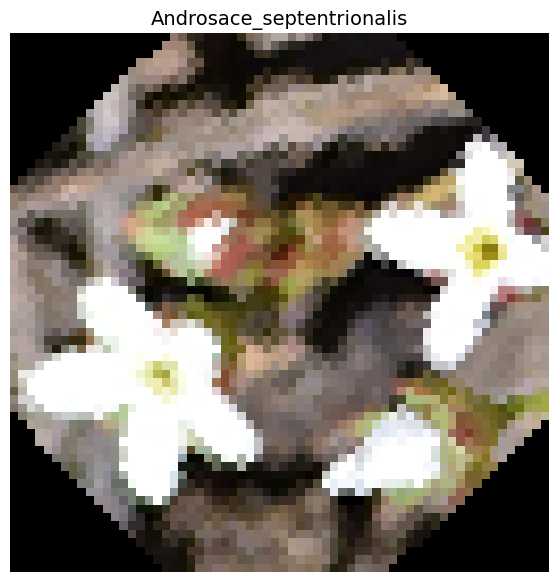

In [22]:
perm_image = image.permute(1,2,0)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(perm_image)
plt.axis("off")
plt.title(train_data.classes[label], fontsize=14)

### The Data Loaders


In [23]:
# create dataloaders for train, test, and val splits
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dl = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dl = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
val_dl = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)




In [24]:
img, label = next(iter(train_dl))

In [25]:
img.shape

torch.Size([32, 3, 64, 64])

We could develop a different dataset, instead of ImageFolder, but we will do that in the next Notebook  
We could also just load a pretrained TinyVGG model, but we'll recreate one for practice
  
VGG16 is 30 layers, so a bit of a pain  
VGG models also take in 64 x 64 images, so... 


In [26]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*13*13,#*72*72,#*69*69,#*26*26,#*29*29,#*13*13, #initially no 13 x 13
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape) # running this will tell us what the size should be for the classifier 'in_features'
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html

In [27]:
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=66, bias=True)
  )
)

In [28]:
#quick test on the model to see if it will work
im_batch, lab_batch = next(iter(train_dl))
im_batch.shape, lab_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

The first item is the batch size

In [29]:
# try a forward pass, sending the batch tensors to the GPU
model_0(im_batch.to(device))

tensor([[-0.0042,  0.0184,  0.0432,  ..., -0.0060,  0.0038,  0.0233],
        [-0.0053,  0.0124,  0.0441,  ..., -0.0079,  0.0032,  0.0141],
        [-0.0029,  0.0164,  0.0418,  ..., -0.0047,  0.0018,  0.0212],
        ...,
        [ 0.0012,  0.0145,  0.0452,  ..., -0.0098,  0.0043,  0.0203],
        [-0.0047,  0.0159,  0.0407,  ..., -0.0102, -0.0002,  0.0187],
        [-0.0025,  0.0157,  0.0462,  ..., -0.0174,  0.0018,  0.0180]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])
#summary(model_0, input_size=[12, 3, 300, 300])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 66]                   --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

For the time being, we'll just do this the long way


In [31]:

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    if y_true.shape != y_pred.shape:
        print(f"Different lengths somehow: y_pred: {y_pred.shape}, y_true: {y_true.shape}")
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [32]:
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [33]:
# tqdm gives us progress bars
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [34]:
train_time_start = timer()

EPOCHS = 200  # make this higher!

# Setup loss function and optimizer
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}


##############################    Train loop  #####################################
for epoch in tqdm(range(EPOCHS)):
    print("Epoch:", epoch)
    
    #put model into training mode
    model_0.train()
    
    #keep track of loss
    training_loss = 0
    training_acc = 0

    #Batch processing
    for batch, (X, y) in enumerate(train_dl):
        #send data to gpu if we have one
        X, y = X.to(device), y.to(device)

        #Forward pass thru the network
        y_pred = model_0(X)

        # Loss Calculation
        loss = loss_function(y_pred, y)
        training_loss += loss.item()

        # zero grad the optimizer ( need to do this every loop or it accumulates)
        optimizer.zero_grad()

        #Back propagate
        loss.backward()

        # step the optimizer
        optimizer.step()

        # Convert from logits
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        # Calculate accuracy metric
        training_acc += accuracy_fn(y_pred=y_pred_class,y_true=y)

        #print out a current status
        # if batch %100 ==0:
        #     print("Percent Processed:", batch * len(X)/len(train_dl.dataset))
    
    #avg training loss calculation for the epoch
    training_loss /= len(train_dl)
    training_acc /= len(train_dl)

    ##########################    Test Loop    ####################################
    test_loss = 0
    test_accuracy = 0

    #put model into eval mode
    model_0.eval()
    #put pytorch into inference mode (I think there also another method for turning off gradients, but this is preferred)
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dl):
            #gotta put these on the gpu
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Forward pass again
            test_pred = model_0(X_test) #logits
            #calculate test loss
            loss = loss_function(test_pred, y_test)
            test_loss += loss.item()
            # Calculate the batch accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            batch_accuracy = accuracy_fn(y_pred=test_pred_labels, y_true=y_test)
            test_accuracy += accuracy_fn(y_pred=test_pred_labels, y_true=y_test)
           # print("Batch Test Acc: ", batch_accuracy)
        # epoch test loss
        test_loss /=len(test_dl)
        # epoch test accuracy
        test_accuracy /=len(test_dl)

    results["train_loss"].append(training_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(training_acc)
    results["test_acc"].append(test_accuracy)
    # print status at end of each epoch
    print(f"Training Loss: {training_loss:0.4f} | Test Loss: {test_loss:0.4f} | Training Accuracy {training_acc:0.4f} | Test Accuracy: {test_accuracy:0.4f}")

# Calculate training time
train_time_end = timer() 
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0


/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training Loss: 4.1541 | Test Loss: 4.1431 | Training Accuracy 3.0120 | Test Accuracy: 3.1829
Epoch: 1
Training Loss: 4.1386 | Test Loss: 4.1225 | Training Accuracy 3.1277 | Test Accuracy: 3.1829
Epoch: 2
Training Loss: 4.1313 | Test Loss: 4.1202 | Training Accuracy 3.1277 | Test Accuracy: 3.1829
Epoch: 3
Training Loss: 4.1302 | Test Loss: 4.1201 | Training Accuracy 2.7700 | Test Accuracy: 3.1197
Epoch: 4
Training Loss: 4.1296 | Test Loss: 4.1200 | Training Accuracy 2.8238 | Test Accuracy: 3.2092
Epoch: 5
Training Loss: 4.1299 | Test Loss: 4.1206 | Training Accuracy 2.9394 | Test Accuracy: 3.0671
Epoch: 6
Training Loss: 4.1299 | Test Loss: 4.1205 | Training Accuracy 2.7512 | Test Accuracy: 3.1829
Epoch: 7
Training Loss: 4.1296 | Test Loss: 4.1198 | Training Accuracy 2.7673 | Test Accuracy: 3.2618
Epoch: 8
Training Loss: 4.1298 | Test Loss: 4.1197 | Training Accuracy 2.8238 | Test Accuracy: 3.1829
Epoch: 9
Training Loss: 4.1295 | Test Loss: 4.1200 | Training Accuracy 2.9798 | Test Accura

In [72]:
len(test_dl)

11

In [73]:
len(train_dl)

32

In [74]:
#quick test on the model to see how bad it is
im_batch, lab_batch = next(iter(test_dl))
#im_batch.shape, lab_batch.shape

quick_results = model_0(im_batch.to(device))

In [75]:
im_batch

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [76]:
quick_results

tensor([[ -1.7561,  -6.2916,  -1.6861,  -2.6733,   1.3969],
        [ -0.7780,  -5.6312,  -0.1802,   0.5444,   0.3187],
        [  2.5238,  -0.6052,  -0.9582,  -1.9020,  -2.3791],
        [ -1.8220,  -2.0770,   0.7141,   1.4252,   0.2232],
        [  1.7864,  -0.1662,  -0.7535,  -2.9932,  -2.0219],
        [  2.5382,  -0.8449,  -1.0759,  -2.3362,  -1.6087],
        [-10.1078,  17.6061, -10.4958, -18.3186,  -0.8589],
        [  3.5796,  -1.1657,  -1.6772,  -2.6829,  -2.2086],
        [ -8.5962,  14.4726,  -6.3235, -17.3870,  -2.4570],
        [  3.4735,  -0.9638,  -1.5422,  -2.5048,  -2.2915],
        [ -1.8655,  -0.0250,   0.1266,  -3.3638,  -1.1203],
        [ -3.5912,  10.7141,  -5.9943, -11.6170,  -3.0550],
        [  0.9734,  -0.2626,  -1.3189,  -2.4306,  -1.4620],
        [ -3.8312,  -5.3091,   1.3258,   0.9262,   1.8443],
        [-10.7816,  14.6605,  -3.5496, -13.1960,  -5.0615],
        [-12.9072, -18.3948,  -5.1419,  -8.6320,  11.8642],
        [  0.4690,  -0.8736,  -0.4656,  

In [77]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

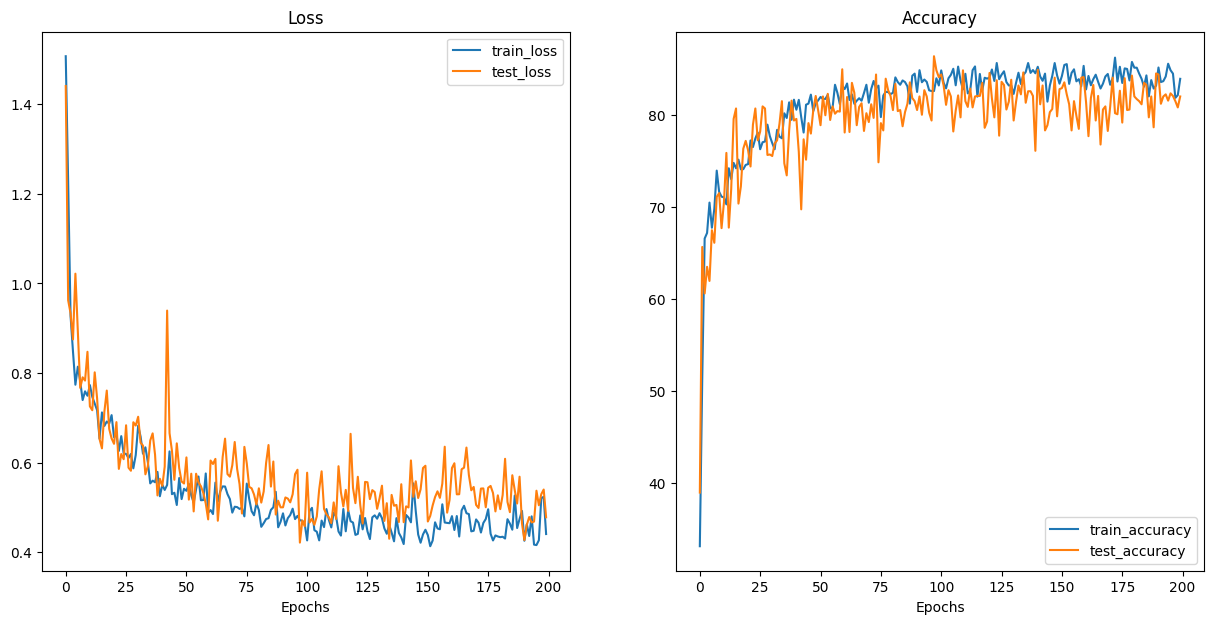

In [78]:
plot_loss_curves(results) 

Hmm... not bad.  

Note, I tried 300x300 images - did not train